In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('/content/diabetes_prediction_dataset.csv')

In [3]:
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [5]:
df.drop_duplicates(inplace = True)
df.shape

(96146, 9)

In [6]:
# features=X.columns.tolist()
# pd.plotting.scatter_matrix(X[features], figsize=(12, 12))
# plt.show()

In [7]:
def cor(df, th):
  corr_mat = df.corr(numeric_only=True)
  corr = set()

  for i in range(len(corr_mat.columns)):
    for j in range(i):
      if abs(corr_mat.iloc[i, j]) > th:
        colname = corr_mat.columns[i]
        corr.add(colname)
  return corr

cor(df,0.9)



set()

In [8]:
df.duplicated().sum()

0

In [9]:
df.select_dtypes(include = ['float64','int64']).columns

Index(['age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level',
       'blood_glucose_level', 'diabetes'],
      dtype='object')

In [10]:
# checking for outliers
def detect_outlier_iqr(df):
  out = {}

  for i in df.select_dtypes(include = ['float64','int64']).columns:
    q1 = df[i].quantile(0.25)
    q3 = df[i].quantile(0.75)

    iqr = q3 - q1
    upper_bound = q3 + 1.5 * iqr
    lower_bound = q1 - 1.5 * iqr

    # out[i] = df[(df[i] > upper_bound) | (df[i] < lower_bound)].index
    out[i] = df[(df[i] > upper_bound) | (df[i] < lower_bound)][i].count()

  return out

In [11]:
detect_outlier_iqr(df) # planning to use tree based algo , hence leaving the outleirs

{'age': 0,
 'hypertension': 7461,
 'heart_disease': 3923,
 'bmi': 5354,
 'HbA1c_level': 1312,
 'blood_glucose_level': 2031,
 'diabetes': 8482}

In [12]:
from sklearn.model_selection import train_test_split

X = df.drop('diabetes', axis=1)
y = df['diabetes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [13]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

ct = ColumnTransformer(
    transformers=[('encoder', OneHotEncoder(), ['gender', 'smoking_history'])],
    remainder='passthrough'  # Keep non-categorical features unchanged
)
# Fit encoder on the training set and transform both training and test sets
X_train = ct.fit_transform(X_train)
X_test = ct.transform(X_test)

# the columns will be changed after encoding
encoded_columns = ct.transformers_[0][1].get_feature_names_out(['gender', 'smoking_history'])

non_encoded_columns = [col for col in X.columns if col not in ['gender', 'smoking_history']]

columns = list(encoded_columns) + non_encoded_columns

X_train_df = pd.DataFrame(X_train, columns=columns)
X_test_df = pd.DataFrame(X_test, columns=columns)

X_train_df.head()

,gender_Female,gender_Male,gender_Other,smoking_history_No Info,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,35.0,0.0,0.0,31.53,6.6,155.0
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.4,0.0,0.0,15.19,4.0,130.0
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,60.0,0.0,0.0,20.90,6.5,100.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,66.0,0.0,0.0,27.05,6.0,130.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,48.0,0.0,0.0,24.05,4.8,145.0


In [14]:
# training with random_forest classifier

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Classification Report: \n{classification_report(y_test, y_pred)}')

Accuracy: 0.9686427457098284
Classification Report: 
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     17509
           1       0.95      0.69      0.80      1721

    accuracy                           0.97     19230
   macro avg       0.96      0.84      0.89     19230
weighted avg       0.97      0.97      0.97     19230



In [16]:
import xgboost as xgb
xgb_model = xgb.XGBClassifier(random_state=42, eval_metric='mlogloss')

xgb_model.fit(X_train_df, y_train)

y_pred_xgb = xgb_model.predict(X_test_df)


print(f'Accuracy: {accuracy_score(y_test, y_pred_xgb)}')
print(f'Classification Report: \n{classification_report(y_test, y_pred_xgb)}')

Accuracy: 0.9702548101924077
Classification Report: 
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     17509
           1       0.96      0.69      0.81      1721

    accuracy                           0.97     19230
   macro avg       0.97      0.85      0.90     19230
weighted avg       0.97      0.97      0.97     19230



In [17]:
# Now lets try out hyperparameter tuning

from sklearn.model_selection import GridSearchCV

In [18]:
# for random forest
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search_rf = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                              param_grid=param_grid_rf,
                              scoring='accuracy',
                              cv=5,
                              verbose=2,
                              n_jobs=-1)

# grid_search_rf.fit(X_train_df, y_train)

# print(f"Best Parameters for Random Forest: {grid_search_rf.best_params_}")

# estm = grid_search_rf.best_estimator_
# y_pred_rf = estm.predict(X_test_df)

# print(f'Accuracy: {accuracy_score(y_test, y_pred_rf)}')
# print(f'Classification Report: \n{classification_report(y_test, y_pred_rf)}')

In [19]:
import torch
print(torch.cuda.is_available())

True


In [20]:
# !pip uninstall -y scikit-learn xgboost
# !pip install scikit-learn xgboost



In [21]:
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.3.1


Found existing installation: scikit-learn 1.3.1
Uninstalling scikit-learn-1.3.1:
  Successfully uninstalled scikit-learn-1.3.1
  Using cached scikit_learn-1.3.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
Using cached scikit_learn-1.3.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (10.8 MB)


In [22]:
#for xgboost

from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report

param_dist_xgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

random_search_xgb = RandomizedSearchCV(estimator=xgb.XGBClassifier(random_state=42,tree_method='gpu_hist',device='cuda',eval_metric='mlogloss'),
                                       param_distributions=param_dist_xgb,
                                       scoring='accuracy',
                                       n_iter=10,  # number of random combinations to try
                                       cv=5,
                                       verbose=2,
                                       n_jobs=-1,
                                       random_state=42)

# Fit the RandomizedSearchCV with training data
random_search_xgb.fit(X_train_df, y_train)

# Print the best parameters found by RandomizedSearchCV
print(f"Best Parameters for XGBoost: {random_search_xgb.best_params_}")

# Get the best estimator (model) from the random search
estm_xgb = random_search_xgb.best_estimator_

# Make predictions with the best model
y_pred_xgb = estm_xgb.predict(X_test_df)

# Print accuracy and classification report
print(f'Accuracy: {accuracy_score(y_test, y_pred_xgb)}')
print(f'Classification Report: \n{classification_report(y_test, y_pred_xgb)}')


Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:20:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Best Parameters for XGBoost: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
Accuracy: 0.9709828393135725
Classification Report: 
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     17509
           1       0.99      0.69      0.81      1721

    accuracy                           0.97     19230
   macro avg       0.98      0.84      0.90     19230
weighted avg       0.97      0.97      0.97     19230



/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:20:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:20:56] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


In [23]:
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search_xgb = GridSearchCV(estimator=xgb.XGBClassifier(random_state=42,tree_method='gpu_hist',device='cuda', eval_metric='mlogloss'),
                               param_grid=param_grid_xgb,
                               scoring='accuracy',
                               cv=5,
                               verbose=2,
                               n_jobs=-1)

grid_search_xgb.fit(X_train_df, y_train)

print(f"Best Parameters for XGBoost: {grid_search_xgb.best_params_}")

estm_xg = grid_search_xgb.best_estimator_
y_pred_xgb = estm_xg.predict(X_test_df)

print(f'Accuracy: {accuracy_score(y_test, y_pred_xgb)}')
print(f'Classification Report: \n{classification_report(y_test, y_pred_xgb)}')

Fitting 5 folds for each of 108 candidates, totalling 540 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:24:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Best Parameters for XGBoost: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Accuracy: 0.971086843473739
Classification Report: 
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     17509
           1       0.99      0.69      0.81      1721

    accuracy                           0.97     19230
   macro avg       0.98      0.84      0.90     19230
weighted avg       0.97      0.97      0.97     19230



/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:24:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


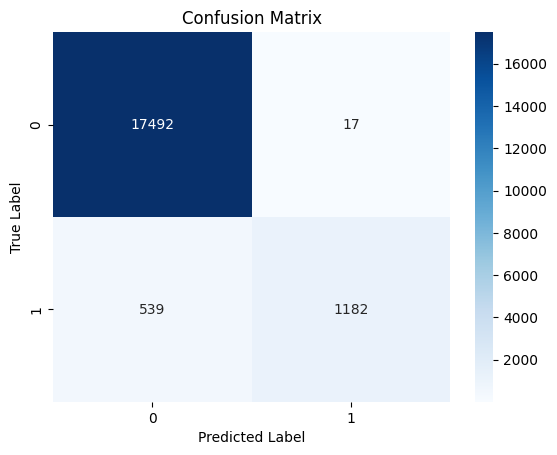

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred_xgb)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

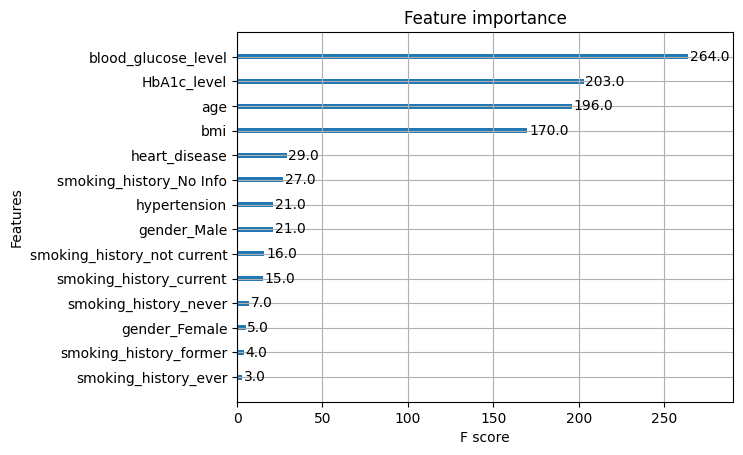

In [28]:
# # Plot feature importance
# xgb.plot_importance(y_pred_xgb)
# plt.show()
xgb.plot_importance(estm_xg)
plt.show()


In [29]:
import joblib

In [30]:
joblib.dump(estm_xg, 'xgb_model.pkl')
# To load the model later
# loaded_model = joblib.load('xgboost_model.pkl')

['xgb_model.pkl']

In [31]:
import pickle

# Save the model to a file using pickle
with open('xgboost_model.pkl', 'wb') as file:
    pickle.dump(estm_xg, file)


In [32]:
import pickle

# Load the model from the file
# with open('xgboost_model.pkl', 'rb') as file:
#     loaded_model = pickle.load(file)

# You can now use the loaded_model for predictions
# y_pred = loaded_model.predict(X_test_df)